Note: Google collab doesn't support OpenCV. So please open it in Jupiter notebook or the local machine instead 😀.

#Install modules


In [ ]:
!pip install opencv-python
!pip install keras
!pip install tensorflow #Use pip install tensorflow-cpu if cuda is not available

#Import modules

In [1]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from keras import backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Activation, LSTM
import h5py

#Initial variables



In [2]:
DIR_TR = "dataset/Train/"
DIR_TE = "dataset/Test/"
DIR_VA = "dataset/Valid/"

# Frame size  
IMG_SIZE = 224
IMG_SIZE_TUPLE = (IMG_SIZE, IMG_SIZE)

# Number of channels (RGB)
NUM_CHANNELS = 3
# Flat frame size
IMG_SIZE_FLAT = IMG_SIZE**2 * NUM_CHANNELS

# Number of classes for classification (Violence-No Violence)
NUM_CLASSES = 2
CLASSES_LIST = ['NonViolence', 'Violence']
assert len(CLASSES_LIST) == NUM_CLASSES

SEQUENCE_LENGTH = 20

#VGG16 Model

In [ ]:
image_model = VGG16(include_top=True, weights='imagenet')
image_model.summary()

In [ ]:
transfer_layer = image_model.get_layer('fc2')
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


#Frame extraction function

## Function

Get array of each frame

In [ ]:
def get_frames(vid_path):
    cap = cv2.VideoCapture(vid_path)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    split_size = int(min(3, max(total_frames // SEQUENCE_LENGTH, 1)))
    chunk_size = total_frames / split_size
    skip_frame = max(1, chunk_size // SEQUENCE_LENGTH)
    
    for c in range(split_size):
        initial_frame = SEQUENCE_LENGTH * c * skip_frame
        
        frames_list = []
        for i in range(SEQUENCE_LENGTH):
            cap.set(cv2.CAP_PROP_POS_FRAMES, (i * skip_frame) + initial_frame)
            ret, frame = cap.read()
            if not ret:
                break
            
            RGB_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
            res = cv2.resize(RGB_img, 
                             dsize=IMG_SIZE_TUPLE,
                             interpolation=cv2.INTER_CUBIC)
            
            frames_list.append(res)

            
        if len(frames_list) != SEQUENCE_LENGTH:
            continue
        
        result = np.array(frames_list)
        result = (result / 255).astype(np.float16)
        
        yield result
        

Extract features each frame from video

In [ ]:
def extracted_features(vid_path):
    gen = get_frames(vid_path)
    for chunk in gen:
        shape = (SEQUENCE_LENGTH, 4096)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        transfer_values = image_model_transfer.predict(chunk)
        
        yield transfer_values
    

Create dataset

In [ ]:
def create_dataset(dataset_dir):
    class_dataset_dir = os.listdir(dataset_dir)
    features = []
    labels = []
    count = 0
    
    for dir in class_dataset_dir:
        videos_list = os.listdir(os.path.join(dataset_dir, dir))
        
        for vid in videos_list:
            gen_path = os.path.join(dataset_dir, dir, vid)
            gen = extracted_features(gen_path)
            for chunk in gen:
                features.append(chunk)
                if dir == CLASSES_LIST[0]:
                    labels.append([1, 0])
                elif dir == CLASSES_LIST[1]:
                    labels.append([0, 1])
            count += 1
            print(gen_path, count, len(videos_list))
    
    return features, labels

##Create dataset for video

Note: Please skip this section if you already save the dataset.

In [ ]:
features_tr, labels_tr = create_dataset(DIR_TR)
features_te, labels_te = create_dataset(DIR_TE)
features_va, labels_va = create_dataset(DIR_VA)

##Write and load dataset

After you finish the create dataset section. Uncomment this below code to save the dataset and when you've done, Comment it again to make sure you won't overwrite it.

In [ ]:
#   Write Data

# with h5py.File('features_labels/datav6.h5', mode='w') as file:
#     file.create_dataset('X_tr', data=features_tr)
#     file.create_dataset('X_te', data=features_te)
#     file.create_dataset('X_va', data=features_va)
    
#     file.create_dataset('y_tr', data=labels_tr)
#     file.create_dataset('y_te', data=labels_te)
#     file.create_dataset('y_va', data=labels_va)

Load the dataset from hdf5 file

In [ ]:
#   Load Data

# with h5py.File('features_labels/datav6.h5', mode='r') as file:
#     X_te = file['X_te'][:]
#     y_te = file['y_te'][:]

#     X_tr = file['X_tr'][:]
#     y_tr = file['y_tr'][:]

#     X_va = file['X_va'][:]
#     y_va = file['y_va'][:]


In [21]:
with h5py.File('/content/drive/MyDrive/Colab Notebooks/Aibuilder Project/Violence Detection/features_labels/last_final_v1_train.h5', mode='r') as file:
    X_tr = file['X_tr'][:]
    y_tr = file['y_tr'][:]


In [22]:
with h5py.File('/content/drive/MyDrive/Colab Notebooks/Aibuilder Project/Violence Detection/features_labels/last_final_v1_val.h5', mode='r') as file:
    X_va = file['X_va'][:]
    y_va = file['y_va'][:]

In [14]:
with h5py.File('/content/drive/MyDrive/Colab Notebooks/Aibuilder Project/Violence Detection/features_labels/last_final_v1_test.h5', mode='r') as file:
    X_te = file['X_te'][:]
    y_te = file['y_te'][:]

##Check data

In [23]:
print("Train features", len(X_tr))
print("Test features", len(X_te))
print("Validation features", len(X_va))

Train features 4836
Test features 738
Validation features 1378


In [24]:
print("Train label", len(y_tr))
print("Test label", len(y_te))
print("Validation label", len(y_va))

Train label 4836
Test label 738
Validation label 1378


#LSTM model

##Create model


In [7]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))


##Train model

In [8]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
epoch = 50
batchS = 300

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 12, mode = 'min', restore_best_weights = True)
opt = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
history = model.fit(x=np.array(X_tr), y=np.array(y_tr), epochs=epoch,
                    validation_data=(np.array(X_va), np.array(y_va)),
                    shuffle=True,
                    batch_size=batchS, verbose=2,
                    callbacks=[early_stopping_callback])

Epoch 1/50
17/17 - 9s - loss: 0.2727 - accuracy: 0.5362 - val_loss: 0.2442 - val_accuracy: 0.5697 - 9s/epoch - 537ms/step
Epoch 2/50
17/17 - 2s - loss: 0.2438 - accuracy: 0.5928 - val_loss: 0.2415 - val_accuracy: 0.5697 - 2s/epoch - 127ms/step
Epoch 3/50
17/17 - 2s - loss: 0.2314 - accuracy: 0.6288 - val_loss: 0.2131 - val_accuracy: 0.6640 - 2s/epoch - 127ms/step
Epoch 4/50
17/17 - 2s - loss: 0.1938 - accuracy: 0.7057 - val_loss: 0.2148 - val_accuracy: 0.6684 - 2s/epoch - 125ms/step
Epoch 5/50
17/17 - 2s - loss: 0.1945 - accuracy: 0.7086 - val_loss: 0.1813 - val_accuracy: 0.7373 - 2s/epoch - 126ms/step
Epoch 6/50
17/17 - 2s - loss: 0.1668 - accuracy: 0.7531 - val_loss: 0.1742 - val_accuracy: 0.7504 - 2s/epoch - 126ms/step
Epoch 7/50
17/17 - 2s - loss: 0.1485 - accuracy: 0.7880 - val_loss: 0.1618 - val_accuracy: 0.7656 - 2s/epoch - 142ms/step
Epoch 8/50
17/17 - 2s - loss: 0.1390 - accuracy: 0.8052 - val_loss: 0.1720 - val_accuracy: 0.7366 - 2s/epoch - 131ms/step
Epoch 9/50
17/17 - 2s - 

### Old data

In [12]:
with h5py.File('/content/drive/MyDrive/Colab Notebooks/Aibuilder Project/Violence Detection/features_labels/datav6.h5', mode='r') as file:
    # X_te = file['X_te'][:]
    # y_te = file['y_te'][:]

    X_tr = file['X_tr'][:]
    y_tr = file['y_tr'][:]

    X_va = file['X_va'][:]
    y_va = file['y_va'][:]


In [13]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
epoch = 50
batchS = 300

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 12, mode = 'min', restore_best_weights = True)

opt = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
history = model.fit(x=np.array(X_tr), y=np.array(y_tr), epochs=epoch,
                    validation_data=(np.array(X_va), np.array(y_va)),
                    shuffle=True,
                    batch_size=batchS, verbose=2,
                    callbacks=[early_stopping_callback])

Epoch 1/50
15/15 - 5s - loss: 0.4331 - accuracy: 0.5501 - val_loss: 0.4377 - val_accuracy: 0.5334 - 5s/epoch - 307ms/step
Epoch 2/50
15/15 - 2s - loss: 0.3742 - accuracy: 0.5135 - val_loss: 0.2602 - val_accuracy: 0.4666 - 2s/epoch - 135ms/step
Epoch 3/50
15/15 - 2s - loss: 0.2529 - accuracy: 0.5056 - val_loss: 0.2484 - val_accuracy: 0.5334 - 2s/epoch - 135ms/step
Epoch 4/50
15/15 - 2s - loss: 0.2476 - accuracy: 0.5883 - val_loss: 0.2455 - val_accuracy: 0.5980 - 2s/epoch - 135ms/step
Epoch 5/50
15/15 - 2s - loss: 0.2419 - accuracy: 0.6438 - val_loss: 0.2375 - val_accuracy: 0.6782 - 2s/epoch - 137ms/step
Epoch 6/50
15/15 - 2s - loss: 0.2275 - accuracy: 0.7404 - val_loss: 0.2188 - val_accuracy: 0.7065 - 2s/epoch - 138ms/step
Epoch 7/50
15/15 - 2s - loss: 0.1929 - accuracy: 0.7518 - val_loss: 0.1947 - val_accuracy: 0.6987 - 2s/epoch - 145ms/step
Epoch 8/50
15/15 - 2s - loss: 0.1631 - accuracy: 0.7711 - val_loss: 0.1767 - val_accuracy: 0.7231 - 2s/epoch - 160ms/step
Epoch 9/50
15/15 - 2s - 

##Evaluate model

In [15]:
result = model.evaluate(np.array(X_te), np.array(y_te))

24/24 [==============================] - 0s 14ms/step - loss: 0.1772 - accuracy: 0.7480


In [17]:
for name, value in zip(model.metrics_names, result):
    print(name, value)


loss 0.1771789938211441
accuracy 0.7479674816131592


##Plot graph

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


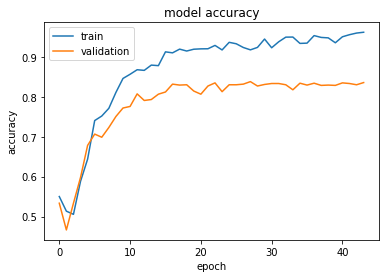

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


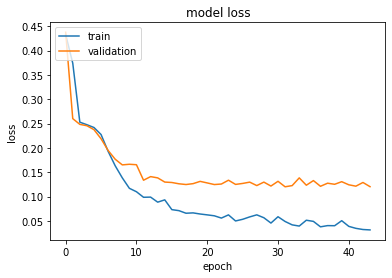

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()


##Save model

In [18]:
model.save('modelv4_5.h5')
model.save_weights('w_modelv4_5.h5')